In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- helpers ----------
def get_dataset(name: str):
    n = name.lower()
    if "cifar100" in n: return "cifar100"
    if "cifar10"  in n: return "cifar10"
    m = re.search(r"_c(\d+)", name, re.I)
    return f"c{m.group(1)}" if m else "unknown"

def get_pt_epochs(name: str, pretrain_field: int):
    m = re.search(r"_e(\d+)", name)
    return int(m.group(1)) if m else int(pretrain_field or 0)

def is_baseline(name: str):
    return name.lower().startswith("baseline")

def is_pretrained(name: str):
    n = name.lower()
    # extend as you add methods
    return n.startswith(("simclr","byol","simsiam","barlow"))
    
def get_pt_epochs(name: str, pretrain_field=None):
    n = name.lower()
    # explicit "preE-<k>" takes priority: simclr_cifar10_preE-5_supE-10...
    m = re.search(r"pre[e-]?[-_]?(\d+)", n)        # matches preE-5, pre-5, pree5
    if m: return int(m.group(1))
    # special-case pure SSL dirs like: simclr_cifar10_e100_s1
    if is_pretrained(n):
        m2 = re.search(r"(?:^|[_-])e(\d+)(?:$|[_-])", n)
        if m2: return int(m2.group(1))
    # fallback (rare): use provided field if any
    return int(pretrain_field or 0)

def strip_seed(name: str):
    """Remove seed pattern like '_s-1' or 's1' from experiment name."""
    return re.sub(r"[_-]s[-_]?\d+$", "", name)

def ci_get(df, names):
    if df is None or df.empty: return None
    if isinstance(names, str): names = [names]
    low = {c.lower(): c for c in df.columns}
    for n in names:
        if n in df.columns: return df[n]
        if n.lower() in low: return df[low[n.lower()]]
    return None

def get_ssl_method(name: str):
    n = str(name).lower()

    # more specific first
    if n.startswith("baseline-imagenet"):
        return "baseline-imagenet"

    for m in ("simclr", "byol", "simsiam", "barlow"):
        if n.startswith(m):
            return m

    if n.startswith("baseline"):
        return "baseline"

    return "unknown"

def extract_metrics_from_csv(csv_path: Path):
    if not csv_path.exists():
        return (None, None, None)
    try:
        df = pd.read_csv(csv_path)
    except Exception:
        return (None, None, None)
    acc_ser = ci_get(df, ["test_acc","val_acc","accuracy","acc","top1"])
    acc_val = None
    if acc_ser is not None:
        acc_val = pd.to_numeric(acc_ser, errors="coerce").dropna()
        if len(acc_val):
            acc_val = float(acc_val.iloc[-1])
            if acc_val <= 1.5:
                acc_val *= 100.0
    f1_ser = ci_get(df, ["cl_f1","f1","F1"])
    f1_val = None
    if f1_ser is not None:
        f1_vals = pd.to_numeric(f1_ser, errors="coerce").dropna()
        if len(f1_vals):
            f1_val = float(f1_vals.iloc[-1]) * (100.0 if f1_vals.iloc[-1] <= 1.5 else 1.0)
    ba_ser = ci_get(df, ["cl_bal_acc","balanced_accuracy","bal_acc","BA"])
    ba_val = None
    if ba_ser is not None:
        ba_vals = pd.to_numeric(ba_ser, errors="coerce").dropna()
        if len(ba_vals):
            ba_val = float(ba_vals.iloc[-1]) * (100.0 if ba_vals.iloc[-1] <= 1.5 else 1.0)
    return (acc_val, f1_val, ba_val)

def aggregate_metric(df_in, metric):
    df = df_in.dropna(subset=[metric]).copy()

    # Ensure SSL_method exists (some callers may pass a filtered df without it)
    if "SSL_method" not in df.columns:
        def _infer_ssl(name: str):
            n = str(name).lower()
            if n.startswith("baseline-imagenet"):
                return "baseline-imagenet"
            for m in ("simclr", "byol", "simsiam", "barlow"):
                if n.startswith(m):
                    return m
            if n.startswith("baseline"):
                return "baseline"
            return "unknown"
        src = "exp" if "exp" in df.columns else ("exp_base" if "exp_base" in df.columns else None)
        df["SSL_method"] = df[src].map(_infer_ssl) if src else "unknown"

    g = (df.groupby(["dataset", "SSL_method", "noise", "pt_epochs"], as_index=False)[metric]
            .mean(numeric_only=True)
            .sort_values(["dataset", "SSL_method", "pt_epochs", "noise"]))
    return g



def _plot_metric(agg_df, metric_name: str, ylabel: str):
    for ds, g in agg_df.groupby("dataset"):
        plt.figure(figsize=(6, 4))

        # --- Standard baseline (red solid) ---
        base_std = g[g["SSL_method"].str.lower() == "baseline"]
        if not base_std.empty:
            for method, gb in base_std.groupby("SSL_method"):
                gb = gb.sort_values("noise")
                plt.plot(
                    gb["noise"],
                    gb[metric_name],
                    marker="o",
                    linewidth=2.5,
                    color="red",
                    linestyle="--",
                    label=f"{method} (pt=0)"
                )

        # --- Baseline-ImageNet (orange dashed) ---
        base_im = g[g["SSL_method"].str.lower() == "baseline-imagenet"]
        if not base_im.empty:
            for method, gb in base_im.groupby("SSL_method"):
                gb = gb.sort_values("noise")
                plt.plot(
                    gb["noise"],
                    gb[metric_name],
                    marker="o",
                    linewidth=2.5,
                    color="orange",
                    linestyle="--",
                    label=f"{method} (ImageNet)"
                )
        # --- SSL lines ---
        nonbase = g[(g["pt_epochs"] > 0) & (g["SSL_method"].str.lower() != "baseline")]
        if not nonbase.empty:
            groups = sorted(
                nonbase.groupby(["SSL_method", "pt_epochs"]),
                key=lambda t: (t[0][0], t[0][1])
            )
            cmap = plt.cm.viridis
            colors = cmap(np.linspace(0.1, 0.95, len(groups)))

            for color, ((method, pe), sub) in zip(colors, groups):
                sub = sub.sort_values("noise")
                plt.plot(
                    sub["noise"],
                    sub[metric_name],
                    marker="o",
                    linewidth=2.0,
                    color=color,
                    label=f"{method} (e={pe})"
                )

        # --- Final plot styling ---
        plt.title(f"{ylabel} vs Corruption Rate — {ds}")
        plt.xlabel("Corruption rate (noise)")
        plt.ylabel(ylabel)
        plt.grid(True, alpha=0.3)
        plt.legend(title="Method", ncol=2)
        plt.tight_layout()
        plt.show()





# ---------- main function ----------
def plot_corruption_curves_for_dataset(dataset: str,
                                       ssl_method: str,
                                       base_dir: Path = Path.cwd(),
                                       results_dir_prefix: str = "results_"):
    """
    Scan results_{dataset} for experiment folders, parse/aggregate metrics, and plot curves.
    Returns (agg_acc, agg_f1, agg_ba) as DataFrames.
    """
    ds_key = dataset
    root = base_dir / f"{results_dir_prefix}{ds_key}"

    # Build results table from folders
    rows = []
    if root.exists():
        for d in sorted(root.glob("*")):
            if not d.is_dir():
                continue
            csv, log = d/"metrics.csv", d/"logs.txt"
    
            acc, f1, bal_acc = extract_metrics_from_csv(csv)
            if acc is None and log.exists():
                try:
                    txt = log.read_text(errors="ignore")
                    m = re.search(r"Final.*Acc.*?([0-9]+(?:\.[0-9]+)?)\s*%", txt, re.I)
                    if m: acc = float(m.group(1))
                except:
                    pass
            if acc is None and f1 is None and bal_acc is None:
                continue
    
            m_noise = re.search(r"noise[-_= ]?(\d*\.?\d+)", d.name, re.I)
            noise = float(m_noise.group(1)) if m_noise else np.nan
            if noise > 1: noise /= 100.0  # accept 50 -> 0.5
    
            rows.append({
                "exp": d.name,
                "noise": noise,
                "acc": acc,
                "f1": f1,
                "bal_acc": bal_acc
            })
    results = pd.DataFrame(rows)
    if results.empty:
        print(f"No results to plot for dataset '{dataset}'. Looked in: {root}")
        return (pd.DataFrame(), pd.DataFrame(), pd.DataFrame())

    # Clean/derive fields
    df = results.copy()
    for col in ["noise","acc","f1","bal_acc"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    
    df["dataset"] = df["exp"].astype(str).map(get_dataset)
    df["pt_epochs"] = [get_pt_epochs(n, None) for n in df["exp"].astype(str)]
    df["is_baseline"] = df["exp"].str.lower().str.startswith("baseline")
    df.loc[df["is_baseline"], "pt_epochs"] = 0
    df["is_pretrained"] = df["exp"].astype(str).map(is_pretrained)
    df["SSL_method"] = df["exp"].astype(str).map(get_ssl_method)

    df.loc[df["is_baseline"], "pt_epochs"] = 0
    df["dataset"] = df["dataset"].fillna("unknown")

    #df_temp = df[df["noise"].isin([0.9])]
    #print(df_temp)

    # --- Group by experiment type (average over seeds) ---
    df["exp_base"] = df["exp"].map(strip_seed)
    
    group_cols = ["exp_base", "dataset", "noise", "pt_epochs"]
    metric_cols = ["acc", "f1", "bal_acc"]
    
    g = df.groupby(group_cols, as_index=False)

    # means over seeds
    df_means  = g[metric_cols].mean(numeric_only=True)
    
    # number of seeds aggregated per group
    df_counts = g.size().rename(columns={"size": "n_seeds"})
    
    # combine
    df_grouped = df_means.merge(df_counts, on=group_cols, how="left")
    
    # Replace exp with the seedless version for plotting
    df = df_grouped.rename(columns={"exp_base": "exp"})
    
    #print(df)
    
    # Metric-specific filtering of pretrain epochs (optional)
    df_acc = df.copy()
    df_f1  = df.copy()
    df_ba  = df.copy()

    # Metric-specific filtering of pretrain epochs
    df_acc = df[~df["pt_epochs"].isin([1])]
    df_acc = df_acc[~df_acc["noise"].isin([0.9])]
    df_f1 = df[~df["pt_epochs"].isin([1, 2])]
    df_f1 = df_f1[~df_f1["noise"].isin([0.0, 0.9])]
    df_ba = df[~df["pt_epochs"].isin([1, 2])]
    df_ba = df_ba[~df_ba["noise"].isin([0.0, 0.9])]


    #df_acc = df.copy()
    #df_f1  = df.copy()
    #df_ba  = df.copy()
    
    # Aggregate
    agg_acc = aggregate_metric(df_acc, "acc")
    agg_f1  = aggregate_metric(df_f1,  "f1")
    agg_ba  = aggregate_metric(df_ba,  "bal_acc")
    

    
    agg_acc = agg_acc[agg_acc["SSL_method"].isin(['baseline', 'baseline-imagenet', ssl_method])]
    agg_f1  = agg_f1[agg_f1["SSL_method"].isin(['baseline', 'baseline-imagenet', ssl_method])]
    agg_ba  = agg_ba[agg_ba["SSL_method"].isin(['baseline', 'baseline-imagenet', ssl_method])]

    


    # Plot
    if not agg_acc.empty: _plot_metric(agg_acc, "acc", "Accuracy (%)")
    #if not agg_f1.empty:  _plot_metric(agg_f1,  "f1",  "F1" + (" (%)" if agg_f1["f1"].max() and agg_f1["f1"].max()>1.5 else ""))
    #if not agg_ba.empty:  _plot_metric(agg_ba,  "bal_acc", "Balanced Accuracy" + (" (%)" if agg_ba["bal_acc"].max() and agg_ba["bal_acc"].max()>1.5 else ""))

    return agg_acc, agg_f1, agg_ba



agg10_acc, agg10_f1, agg10_ba = plot_corruption_curves_for_dataset("C10_long", "simclr")
agg100_acc, agg100_f1, agg100_ba = plot_corruption_curves_for_dataset("C100_long", "simclr")

No results to plot for dataset 'C10_long'. Looked in: /lustre06/project/6031441/dszczeci/SSL_pretrain/results_C10_long
No results to plot for dataset 'C100_long'. Looked in: /lustre06/project/6031441/dszczeci/SSL_pretrain/results_C100_long


In [2]:
def parse_log_epoch_accs(log_path: Path):
    """
    Parse logs.txt and return a dict: {epoch (int): Test(clean)Acc (float, %)}.
    Assumes lines like:
    [Supervised] Epoch 001 | ... | Test(clean)Acc=14.68% | ...
    """
    epoch_to_acc = {}
    if not log_path.exists():
        return epoch_to_acc

    try:
        with log_path.open("r", errors="ignore") as f:
            for line in f:
                m = re.search(
                    r"Epoch\s+(\d+)\s*\|.*?Test\(clean\)Acc=([0-9]+(?:\.[0-9]+)?)%",
                    line
                )
                if m:
                    ep = int(m.group(1))
                    acc = float(m.group(2))  # already in %
                    epoch_to_acc[ep] = acc
    except Exception:
        pass

    return epoch_to_acc


def aggregate_metric(df_in, metric, extra_group_cols=None):
    df = df_in.dropna(subset=[metric]).copy()
    if extra_group_cols is None:
        extra_group_cols = []

    # Ensure SSL_method exists (some callers may pass a filtered df without it)
    if "SSL_method" not in df.columns:
        def _infer_ssl(name: str):
            n = str(name).lower()
            if n.startswith("baseline-imagenet"):
                return "baseline-imagenet"
            for m in ("simclr", "byol", "simsiam", "barlow"):
                if n.startswith(m):
                    return m
            if n.startswith("baseline"):
                return "baseline"
            return "unknown"

        src = "exp" if "exp" in df.columns else ("exp_base" if "exp_base" in df.columns else None)
        df["SSL_method"] = df[src].map(_infer_ssl) if src else "unknown"

    group_cols = ["dataset", "SSL_method", "noise", "pt_epochs"] + list(extra_group_cols)

    g = (df.groupby(group_cols, as_index=False)[metric]
            .mean(numeric_only=True)
            .sort_values(group_cols))
    return g
def plot_corruption_curves_for_dataset(dataset: str,
                                       ssl_method: str,
                                       base_dir: Path = Path.cwd(),
                                       results_dir_prefix: str = "results_",
                                       epochs=None):
    """
    Scan results_{dataset} for experiment folders, parse per-epoch metrics from logs,
    and plot accuracy vs noise for a list of epochs.

    epochs: list of epoch numbers (ints), e.g. [10, 50, 100]
    Returns: dict {epoch: agg_acc_df_for_that_epoch}, empty DataFrames for F1/BA.
    """
    if epochs is None:
        # sensible default – adjust to whatever you care about
        epochs = [10, 50, 100]
    epochs = sorted(set(int(e) for e in epochs))

    ds_key = dataset.lower()
    root = base_dir / f"{results_dir_prefix}{ds_key}"

    rows = []
    if root.exists():
        for d in sorted(root.glob("*")):
            if not d.is_dir():
                continue

            log = d / "logs.txt"
            epoch_to_acc = parse_log_epoch_accs(log)
            if not epoch_to_acc:
                # no usable log for this experiment
                continue

            # parse noise from folder name
            m_noise = re.search(r"noise[-_= ]?(\d*\.?\d+)", d.name, re.I)
            noise = float(m_noise.group(1)) if m_noise else np.nan
            if noise > 1:
                noise /= 100.0  # accept e.g. 50 -> 0.5

            # one row per requested epoch (if present in log)
            for ep in epochs:
                acc = epoch_to_acc.get(ep, None)
                if acc is None:
                    continue

                rows.append({
                    "exp": d.name,
                    "noise": noise,
                    "epoch": ep,
                    "acc": acc,
                    "f1": np.nan,       # no per-epoch F1 in logs
                    "bal_acc": np.nan   # no per-epoch BA in logs
                })

    results = pd.DataFrame(rows)
    if results.empty:
        print(f"No results to plot for dataset '{dataset}' (per-epoch). Looked in: {root}")
        return {}, pd.DataFrame(), pd.DataFrame()

    # Clean/derive fields
    df = results.copy()
    for col in ["noise", "acc"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    df["dataset"] = df["exp"].astype(str).map(get_dataset)
    df["pt_epochs"] = [get_pt_epochs(n, None) for n in df["exp"].astype(str)]
    df["is_baseline"] = df["exp"].str.lower().str.startswith("baseline")
    df.loc[df["is_baseline"], "pt_epochs"] = 0
    df["is_pretrained"] = df["exp"].astype(str).map(is_pretrained)
    df["SSL_method"] = df["exp"].astype(str).map(get_ssl_method)
    df["dataset"] = df["dataset"].fillna("unknown")

    # --- Group by experiment type (average over seeds) ---
    df["exp_base"] = df["exp"].map(strip_seed)

    group_cols = ["exp_base", "dataset", "noise", "pt_epochs", "epoch"]
    metric_cols = ["acc", "f1", "bal_acc"]

    g = df.groupby(group_cols, as_index=False)

    # means over seeds
    df_means = g[metric_cols].mean(numeric_only=True)

    # number of seeds aggregated per group
    df_counts = g.size().rename(columns={"size": "n_seeds"})

    # combine
    df_grouped = df_means.merge(df_counts, on=group_cols, how="left")

    # Replace exp with the seedless version for plotting
    df = df_grouped.rename(columns={"exp_base": "exp"})

    # (optional) any metric-specific filtering you still want (pt_epochs / noise)
    df_acc = df.copy()
    # Example: keep all epochs; if you still want to drop certain pt_epochs/noises, do it here:
    # df_acc = df_acc[~df_acc["pt_epochs"].isin([1])]
    # df_acc = df_acc[~df_acc["noise"].isin([0.9])]

    # Aggregate, keeping epoch as a group dimension
    agg_acc_full = aggregate_metric(df_acc, "acc", extra_group_cols=["epoch"])

    # container: epoch -> aggregated df for that epoch
    epoch_to_agg_acc = {}

    # For each requested epoch, filter and plot
    for ep in epochs:
        agg_acc = agg_acc_full[agg_acc_full["epoch"] == ep].copy()
        if agg_acc.empty:
            print(f"[warn] No data for epoch {ep}")
            continue

        # keep only baseline/baseline-imagenet + requested SSL method
        agg_acc = agg_acc[
            agg_acc["SSL_method"].isin(['baseline', 'baseline-imagenet', ssl_method])
        ]

        if agg_acc.empty:
            print(f"[warn] No matching SSL methods for epoch {ep}")
            continue

        # Plot for this epoch
        _plot_metric(agg_acc, "acc", f"Accuracy (%) @ epoch {ep}")

        # store
        epoch_to_agg_acc[ep] = agg_acc

    return epoch_to_agg_acc, pd.DataFrame(), pd.DataFrame()



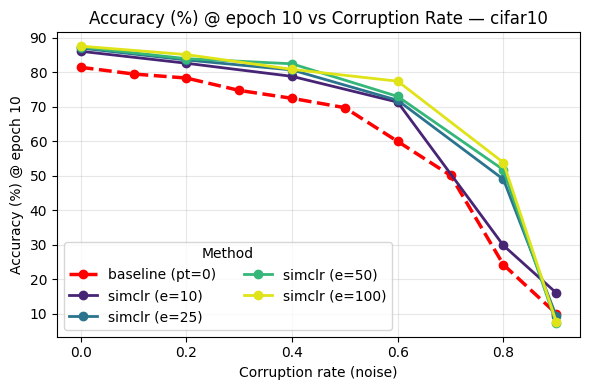

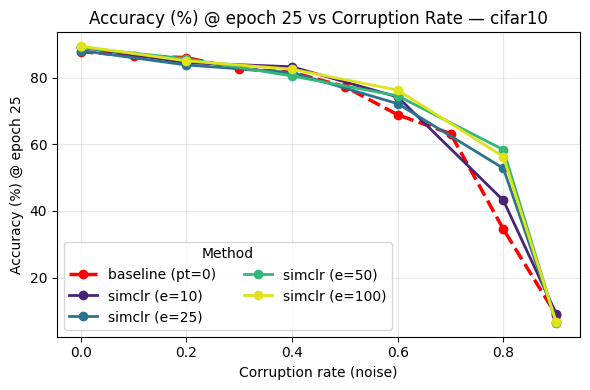

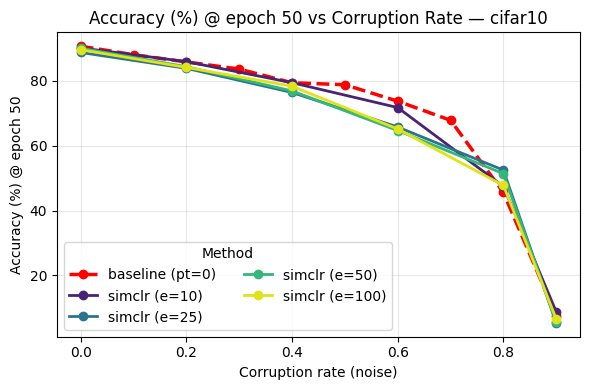

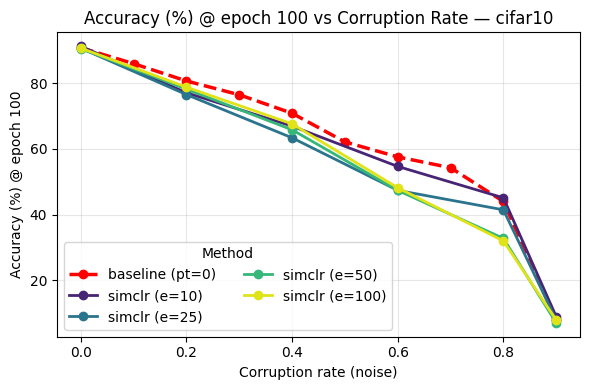

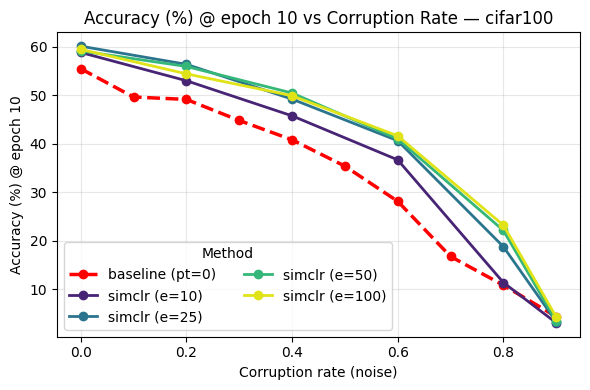

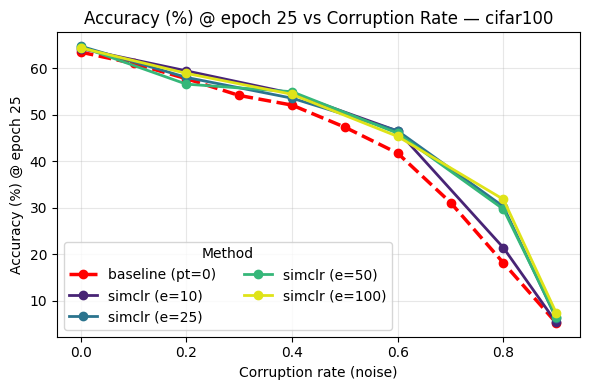

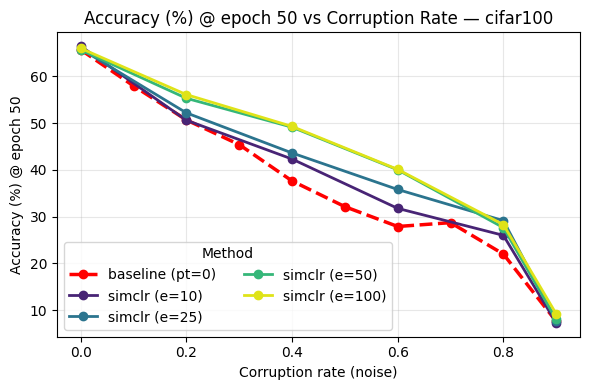

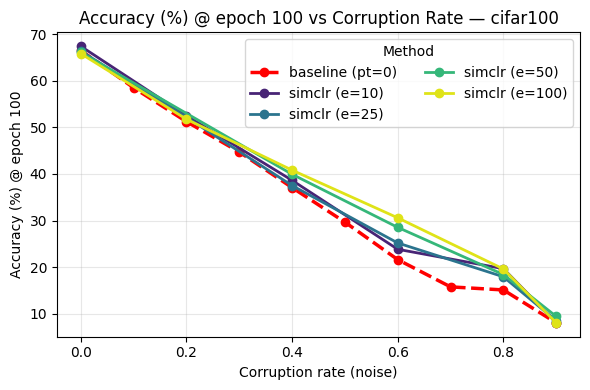

In [3]:
epoch_to_agg10_acc, _, _ = plot_corruption_curves_for_dataset( "c10_long", "simclr", epochs=[10, 25, 50, 100])
epoch_to_agg10_acc, _, _ = plot_corruption_curves_for_dataset( "c100_long", "simclr", epochs=[10, 25, 50, 100])


In [4]:
def parse_log_epoch_curves(log_path: Path):
    """
    Parse logs.txt and return a DataFrame with columns:
    ['epoch', 'test_acc', 'test_loss'].

    Looks for lines like:
    [Supervised] Epoch 001 | ... | Test(clean)Acc=14.68% | TestLoss=2.2221
    """
    rows = []
    if not log_path.exists():
        return pd.DataFrame(columns=["epoch", "test_acc", "test_loss"])

    pat = re.compile(
        r"Epoch\s+(\d+)\s*\|.*?Test\(clean\)Acc=([0-9]+(?:\.[0-9]+)?)%\s*\|\s*TestLoss=([0-9]+(?:\.[0-9]+)?)",
        re.I,
    )

    with log_path.open("r", errors="ignore") as f:
        for line in f:
            m = pat.search(line)
            if not m:
                continue
            ep = int(m.group(1))
            acc = float(m.group(2))      # already in %
            loss = float(m.group(3))
            rows.append({"epoch": ep, "test_acc": acc, "test_loss": loss})

    return pd.DataFrame(rows)

def parse_noise_from_name(name: str):
    m = re.search(r"noise[-_= ]?(\d*\.?\d+)", name, re.I)
    if not m:
        return None
    val = float(m.group(1))
    if val > 1.0:
        val /= 100.0
    return val

def parse_sup_epochs(name: str):
    """
    Extract supervised epochs from exp name, e.g. supE-100, sup-100, supe100.
    Returns int or None.
    """
    n = name.lower()
    m = re.search(r"sup[e-]?[-_]?(\d+)", n)
    return int(m.group(1)) if m else None

def find_experiment_dir(root: Path,
                        method_prefix: str,
                        noise: float,
                        sup_epochs: int | None = None,
                        pre_epochs: int | None = None) -> Path | None:
    """
    Search 'root' (results_<dataset>) for a directory whose name:
      - starts with method_prefix (e.g. 'baseline', 'simclr')
      - has the given noise rate
      - (optionally) matches supE and preE

    Returns the Path to the *first* match found, or None.
    """
    noise = float(noise)

    candidates = []
    for d in sorted(root.glob("*")):
        if not d.is_dir():
            continue
        n = d.name.lower()
        if not n.startswith(method_prefix.lower()):
            continue

        n_noise = parse_noise_from_name(d.name)
        if n_noise is None:
            continue
        # compare with tolerance to handle '0.50' vs '0.5'
        if abs(n_noise - noise) > 1e-6:
            continue

        if sup_epochs is not None:
            supe = parse_sup_epochs(d.name)
            if supe is None or supe != int(sup_epochs):
                continue

        if pre_epochs is not None:
            pree = get_pt_epochs(d.name, None)  # your existing helper
            if pree != int(pre_epochs):
                continue

        candidates.append(d)

    if not candidates:
        return None
    if len(candidates) > 1:
        print(f"[warn] Multiple candidates for {method_prefix}, noise={noise}, "
              f"supE={sup_epochs}, preE={pre_epochs}. Using: {candidates[0].name}")
    return candidates[0]
def plot_pair_learning_curves(dataset: str,
                              noise: float,
                              baseline_supE: int,
                              simclr_preE: int,
                              simclr_supE: int,
                              base_dir: Path = Path.cwd(),
                              results_dir_prefix: str = "results_"):
    """
    Overlay Test(clean)Acc and TestLoss curves for:
      - a baseline experiment
      - a simclr experiment

    Matching is done by:
      - dataset (results_<dataset>)
      - noise
      - supE for baseline
      - preE + supE for simclr
    """
    ds_key = dataset.lower()
    root = base_dir / f"{results_dir_prefix}{ds_key}"

    # --- Find baseline experiment ---
    base_dirpath = find_experiment_dir(
        root,
        method_prefix="baseline",
        noise=noise,
        sup_epochs=baseline_supE,
        pre_epochs=None,          # no pretrain for baseline
    )
    if base_dirpath is None:
        print(f"[error] Could not find baseline exp for noise={noise}, supE={baseline_supE}")
        return

    # --- Find simclr experiment ---
    simclr_dirpath = find_experiment_dir(
        root,
        method_prefix="simclr",
        noise=noise,
        sup_epochs=simclr_supE,
        pre_epochs=simclr_preE,
    )
    if simclr_dirpath is None:
        print(f"[error] Could not find simclr exp for noise={noise}, preE={simclr_preE}, supE={simclr_supE}")
        return

    # --- Parse logs ---
    base_log = base_dirpath / "logs.txt"
    simclr_log = simclr_dirpath / "logs.txt"

    df_base = parse_log_epoch_curves(base_log)
    df_sim = parse_log_epoch_curves(simclr_log)

    if df_base.empty:
        print(f"[error] No epoch curves parsed from {base_log}")
        return
    if df_sim.empty:
        print(f"[error] No epoch curves parsed from {simclr_log}")
        return

    # --- Sort by epoch for safety ---
    df_base = df_base.sort_values("epoch")
    df_sim = df_sim.sort_values("epoch")

    # ------------- Plot: Test Accuracy -------------
    plt.figure(figsize=(6, 2.5))
    plt.plot(df_base["epoch"], df_base["test_acc"],
             marker="o", linewidth=2, color="red", markersize=3,
             label=f"Baseline (No Pre-training)")
    plt.plot(df_sim["epoch"], df_sim["test_acc"],
             marker="o", linewidth=2, color="green", markersize=3,
             label=f"SimCLR SSL ({simclr_preE} epochs)")

    #plt.title(f"Test Accuracy vs Epoch — {dataset}, noise={noise}")
    plt.xlabel("Epoch")
    plt.ylabel("Test Accuracy (%)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    # ---- Save SVG ----
    acc_svg_path = base_dir / f"test_acc_{dataset}_noise{noise}.svg"
    plt.savefig(acc_svg_path, format="svg")

    plt.show()

    # ------------- Plot: Test Loss -------------
    plt.figure(figsize=(6, 2.5))
    plt.plot(df_base["epoch"], df_base["test_loss"],
             marker="o", linewidth=2, color="red", markersize=3,
             label=f"Baseline (No Pre-training)")
    plt.plot(df_sim["epoch"], df_sim["test_loss"],
             marker="o", linewidth=2, color="green", markersize=3,
             label=f"SimCLR SSL ({simclr_preE} epochs)")

    #plt.title(f"Test Loss vs Epoch — {dataset}, noise={noise}")
    plt.xlabel("Epoch")
    plt.ylabel("Test Loss")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    # ---- Save SVG ----
    loss_svg_path = base_dir / f"test_loss_{dataset}_noise{noise}.svg"
    plt.savefig(loss_svg_path, format="svg")

    plt.show()

    print("Baseline exp:", base_dirpath.name)
    print("SimCLR  exp:", simclr_dirpath.name)
    print("Saved:", acc_svg_path)
    print("Saved:", loss_svg_path)




[warn] Multiple candidates for baseline, noise=0.6, supE=100, preE=None. Using: baseline_cifar100_supE-100_noise-0.6_s-1
[warn] Multiple candidates for simclr, noise=0.6, supE=100, preE=25. Using: simclr_cifar100_preE-25_supE-100_noise-0.6_s-1


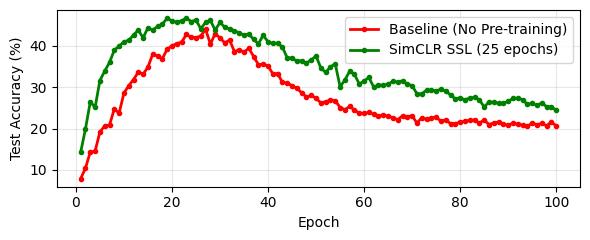

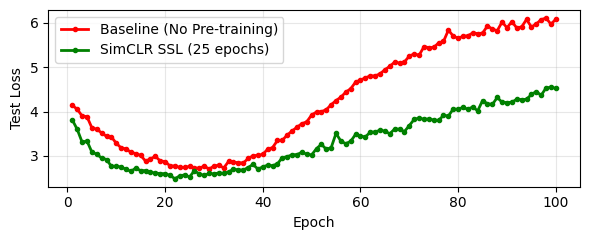

Baseline exp: baseline_cifar100_supE-100_noise-0.6_s-1
SimCLR  exp: simclr_cifar100_preE-25_supE-100_noise-0.6_s-1
Saved: /lustre06/project/6031441/dszczeci/SSL_pretrain/test_acc_c100_long_noise0.6.svg
Saved: /lustre06/project/6031441/dszczeci/SSL_pretrain/test_loss_c100_long_noise0.6.svg


In [5]:
plot_pair_learning_curves(
    dataset="c100_long",
    noise=0.6,
    baseline_supE=100,
    simclr_preE=25,
    simclr_supE=100,
)


[warn] Multiple candidates for baseline, noise=0.6, supE=100, preE=None. Using: baseline_cifar100_supE-100_noise-0.6_s-1
[warn] Multiple candidates for simclr, noise=0.6, supE=100, preE=25. Using: simclr_cifar100_preE-25_supE-100_noise-0.6_s-1


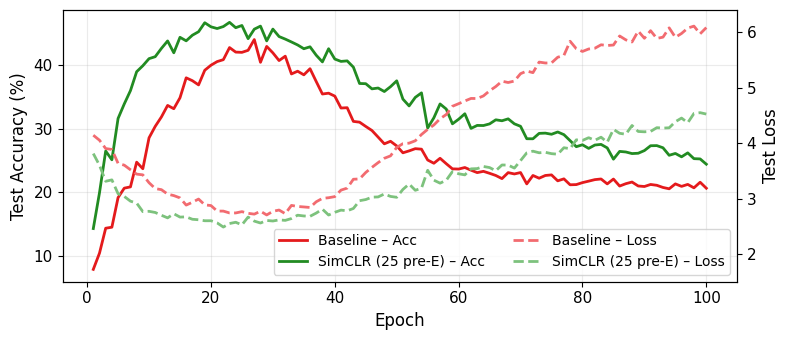

Baseline exp: baseline_cifar100_supE-100_noise-0.6_s-1
SimCLR  exp: simclr_cifar100_preE-25_supE-100_noise-0.6_s-1
Saved combined SVG: /lustre06/project/6031441/dszczeci/SSL_pretrain/acc_loss_c100_long_noise0.6.svg


In [6]:
def plot_pair_learning_curves(dataset: str,
                              noise: float,
                              baseline_supE: int,
                              simclr_preE: int,
                              simclr_supE: int,
                              base_dir: Path = Path.cwd(),
                              results_dir_prefix: str = "results_"):
    ds_key = dataset.lower()
    root = base_dir / f"{results_dir_prefix}{ds_key}"

    # --- Find baseline experiment ---
    base_dirpath = find_experiment_dir(
        root,
        method_prefix="baseline",
        noise=noise,
        sup_epochs=baseline_supE,
        pre_epochs=None,  # no pretrain for baseline
    )
    if base_dirpath is None:
        print(f"[error] Could not find baseline exp for noise={noise}, supE={baseline_supE}")
        return

    # --- Find simclr experiment ---
    simclr_dirpath = find_experiment_dir(
        root,
        method_prefix="simclr",
        noise=noise,
        sup_epochs=simclr_supE,
        pre_epochs=simclr_preE,
    )
    if simclr_dirpath is None:
        print(f"[error] Could not find simclr exp for noise={noise}, preE={simclr_preE}, supE={simclr_supE}")
        return

    # --- Parse logs ---
    base_log = base_dirpath / "logs.txt"
    simclr_log = simclr_dirpath / "logs.txt"

    df_base = parse_log_epoch_curves(base_log)
    df_sim = parse_log_epoch_curves(simclr_log)

    if df_base.empty:
        print(f"[error] No epoch curves parsed from {base_log}")
        return
    if df_sim.empty:
        print(f"[error] No epoch curves parsed from {simclr_log}")
        return

    # --- Sort by epoch for safety ---
    df_base = df_base.sort_values("epoch")
    df_sim = df_sim.sort_values("epoch")

    # ------------- Single graph: Accuracy + Loss -------------
    fig, ax1 = plt.subplots(figsize=(8, 3.5))

    # Easier-to-read font sizes
    ax1.tick_params(axis="both", labelsize=11)
    ax1.set_xlabel("Epoch", fontsize=12)
    ax1.set_ylabel("Test Accuracy (%)", fontsize=12)

    # Left y-axis: accuracy (solid lines)
    ln1 = ax1.plot(
        df_base["epoch"], df_base["test_acc"],
        #marker="o", linewidth=2, markersize=4,
        linewidth=2, markersize=4,
        color="#E41A1C", label="Baseline – Acc"
    )
    ln2 = ax1.plot(
        df_sim["epoch"], df_sim["test_acc"],
        #marker="o", linewidth=2, markersize=4,
        linewidth=2, markersize=4,
        #color="#377EB8", label=f"SimCLR ({simclr_preE} pre-E) – Acc"
        color="#228B22", label=f"SimCLR ({simclr_preE} pre-E) – Acc"
    )

    ax1.grid(True, alpha=0.25)

    # Right y-axis: loss (dashed lines)
    ax2 = ax1.twinx()
    ax2.tick_params(axis="y", labelsize=11)
    ax2.set_ylabel("Test Loss", fontsize=12)

    ln3 = ax2.plot(
        df_base["epoch"], df_base["test_loss"],
        linestyle="--", linewidth=2,
        color="#F26B70", label="Baseline – Loss"
    )
    ln4 = ax2.plot(
        df_sim["epoch"], df_sim["test_loss"],
        linestyle="--", linewidth=2,
        #color="#6FA8DC", label=f"SimCLR ({simclr_preE} pre-E) – Loss"
        color="#7DC27D", label=f"SimCLR ({simclr_preE} pre-E) – Loss"
    )



    # Combine legends from both axes
    lines = ln1 + ln2 + ln3 + ln4
    labels = [l.get_label() for l in lines]

    # Put legend above the plot (less overlap with curves)
    ax1.legend(
        lines, labels,
        loc="lower right",
        #bbox_to_anchor=(0.5, 1.23),
        ncol=2,
        fontsize=10,
        frameon=True
    )

    # Title
    #ax1.set_title(f"{dataset}, noise={noise}: Test Accuracy & Loss vs Epoch", fontsize=13, pad=28)
    ax2.set_ylim(1.5, 6.4)
    fig.tight_layout()

    # Save as SVG
    out_path = base_dir / f"acc_loss_{dataset}_noise{noise}.svg"
    fig.savefig(out_path, format="svg", bbox_inches="tight")

    plt.show()

    print("Baseline exp:", base_dirpath.name)
    print("SimCLR  exp:", simclr_dirpath.name)
    print("Saved combined SVG:", out_path)
plot_pair_learning_curves(
    dataset="c100_long",
    noise=0.6,
    baseline_supE=100,
    simclr_preE=25,
    simclr_supE=100,
)

[warn] Multiple candidates for baseline, noise=0.6, supE=100, preE=None. Using: baseline_cifar100_supE-100_noise-0.6_s-1
[warn] Multiple candidates for simclr, noise=0.6, supE=100, preE=25. Using: simclr_cifar100_preE-25_supE-100_noise-0.6_s-1


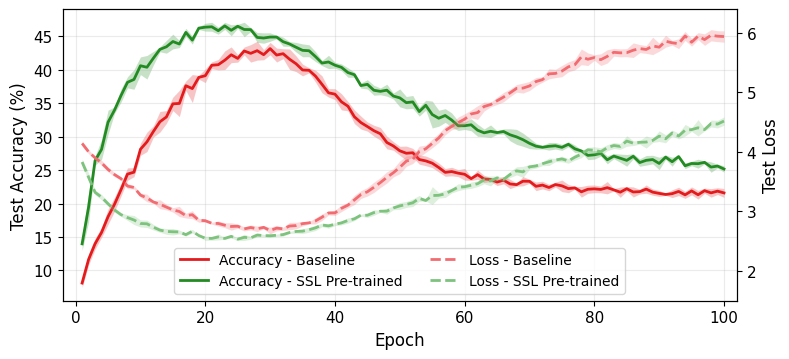

Baseline exps: ['baseline_cifar100_supE-100_noise-0.6_s-1', 'baseline_cifar100_supE-100_noise-0.6_s-2', 'baseline_cifar100_supE-100_noise-0.6_s-3', 'baseline_cifar100_supE-100_noise-0.6_s-4', 'baseline_cifar100_supE-100_noise-0.6_s-5']
SimCLR  exps: ['simclr_cifar100_preE-25_supE-100_noise-0.6_s-1', 'simclr_cifar100_preE-25_supE-100_noise-0.6_s-2', 'simclr_cifar100_preE-25_supE-100_noise-0.6_s-3', 'simclr_cifar100_preE-25_supE-100_noise-0.6_s-4', 'simclr_cifar100_preE-25_supE-100_noise-0.6_s-5']
Saved combined PDF: /lustre06/project/6031441/dszczeci/SSL_pretrain/acc_loss_c100_long_noise0.6_mean_std.pdf


In [8]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

def collect_seed_dirs(root: Path,
                      method_prefix: str,
                      noise: float,
                      sup_epochs: int,
                      pre_epochs: int | None):
    """
    Use your existing find_experiment_dir to get a 'template'
    dir name, then gather all seed variants that share the same stem.
    """
    # Get any one directory that matches this config
    example_dir = find_experiment_dir(
        root,
        method_prefix=method_prefix,
        noise=noise,
        sup_epochs=sup_epochs,
        pre_epochs=pre_epochs,
    )
    if example_dir is None:
        return []

    stem = example_dir.name
    # strip the _sX suffix if present
    if "_s-" in stem:
        stem = stem.rsplit("_s-", 1)[0]

    # collect all dirs that start with that stem and end with _s<number>
    dirs = []
    for d in root.iterdir():
        if not d.is_dir():
            continue
        name = d.name
        if not name.startswith(stem + "_s-"):
            continue
        # optional: ensure the part after _s is numeric
        seed_part = name.split("_s-")[-1]
        if seed_part.isdigit():
            dirs.append(d)

    return sorted(dirs)


def average_seed_curves(exp_dirs: list[Path]):
    """
    Given a list of experiment dirs (one per seed), parse each logs.txt,
    concat, and return an epoch-wise mean DataFrame.
    """
    all_dfs = []

    for d in exp_dirs:
        log_path = d / "logs.txt"
        if not log_path.exists():
            print(f"[warn] Missing log file: {log_path}")
            continue

        df = parse_log_epoch_curves(log_path)
        if df.empty:
            print(f"[warn] No curves parsed from {log_path}")
            continue

        # Optional: keep track of seed (in case you want std later)
        # try to parse the number after _s
        seed = None
        name = d.name
        if "_s" in name:
            seed_str = name.rsplit("_s", 1)[-1]
            if seed_str.isdigit():
                seed = int(seed_str)

        df = df.copy()
        df["seed"] = seed
        all_dfs.append(df)

    if not all_dfs:
        return pd.DataFrame()

    df_all = pd.concat(all_dfs, ignore_index=True)

    # Average metrics per epoch (ignoring seed column)
    metrics = [c for c in df_all.columns
               if c not in ("epoch", "seed") and pd.api.types.is_numeric_dtype(df_all[c])]
    df_mean = (
        df_all
        .groupby("epoch", as_index=False)[metrics]
        .mean()
        .sort_values("epoch")
    )

    return df_mean

def seed_stats(exp_dirs: list[Path]):
    """
    Given a list of experiment dirs (one per seed), parse each logs.txt,
    and return:
      - df_mean: mean metrics per epoch
      - df_std:  std metrics per epoch
      - df_all:  all seed curves stacked (epoch, metrics, seed)
    """
    all_dfs = []

    for d in exp_dirs:
        log_path = d / "logs.txt"
        if not log_path.exists():
            print(f"[warn] Missing log file: {log_path}")
            continue

        df = parse_log_epoch_curves(log_path)
        if df.empty:
            print(f"[warn] No curves parsed from {log_path}")
            continue

        # parse seed from directory name: ..._s1, ..._s2, etc.
        seed = None
        name = d.name
        if "_s" in name:
            seed_str = name.rsplit("_s", 1)[-1]
            if seed_str.isdigit():
                seed = int(seed_str)

        df = df.copy()
        df["seed"] = seed
        all_dfs.append(df)

    if not all_dfs:
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    df_all = pd.concat(all_dfs, ignore_index=True)

    metrics = [
        c for c in df_all.columns
        if c not in ("epoch", "seed") and pd.api.types.is_numeric_dtype(df_all[c])
    ]

    grouped = df_all.groupby("epoch", as_index=False)

    df_mean = grouped[metrics].mean().sort_values("epoch")
    df_std  = grouped[metrics].std(ddof=0).sort_values("epoch")  # population std
    

    return df_mean, df_std, df_all

    

def plot_pair_learning_curves(dataset: str,
                              noise: float,
                              baseline_supE: int,
                              simclr_preE: int,
                              simclr_supE: int,
                              base_dir: Path = Path.cwd(),
                              results_dir_prefix: str = "results_"):
    ds_key = dataset.lower()
    root = base_dir / f"{results_dir_prefix}{ds_key}"

    # --- Find all baseline experiments across seeds ---
    baseline_dirs = collect_seed_dirs(
        root,
        method_prefix="baseline",
        noise=noise,
        sup_epochs=baseline_supE,
        pre_epochs=None,
    )
    if not baseline_dirs:
        print(f"[error] Could not find *any* baseline exps for noise={noise}, supE={baseline_supE}")
        return

    # --- Find all simclr experiments across seeds ---
    simclr_dirs = collect_seed_dirs(
        root,
        method_prefix="simclr",
        noise=noise,
        sup_epochs=simclr_supE,
        pre_epochs=simclr_preE,
    )
    if not simclr_dirs:
        print(f"[error] Could not find *any* simclr exps for noise={noise}, preE={simclr_preE}, supE={simclr_supE}")
        return

    # --- Mean & std over seeds ---
    df_base_mean, df_base_std, _ = seed_stats(baseline_dirs)
    df_sim_mean,  df_sim_std,  _ = seed_stats(simclr_dirs)

    if df_base_mean.empty:
        print(f"[error] No averaged epoch curves for baseline (maybe logs missing?)")
        return
    if df_sim_mean.empty:
        print(f"[error] No averaged epoch curves for simclr (maybe logs missing?)")
        return

    # ------------- Single graph: Accuracy + Loss -------------
    fig, ax1 = plt.subplots(figsize=(8, 3.7))

    ax1.tick_params(axis="both", labelsize=11)
    ax1.set_xlabel("Epoch", fontsize=12)
    ax1.set_ylabel("Test Accuracy (%)", fontsize=12)

    # Left y-axis: mean accuracy (solid lines)
    ln1 = ax1.plot(
        df_base_mean["epoch"], df_base_mean["test_acc"],
        linewidth=2, markersize=4,
        color="#E41A1C", label="Accuracy - Baseline"
    )
    ln2 = ax1.plot(
        df_sim_mean["epoch"], df_sim_mean["test_acc"],
        linewidth=2, markersize=4,
        color="#228B22", label=f"Accuracy - SSL Pre-trained"
    )

    # --- Shaded variability: mean ± std for accuracy ---
    ax1.fill_between(
        df_base_mean["epoch"],
        df_base_mean["test_acc"] - df_base_std["test_acc"],
        df_base_mean["test_acc"] + df_base_std["test_acc"],
        color="#E41A1C",
        alpha=0.25,
        linewidth=0,
        label="_nolegend_",  # don't show in legend
    )
    ax1.fill_between(
        df_sim_mean["epoch"],
        df_sim_mean["test_acc"] - df_sim_std["test_acc"],
        df_sim_mean["test_acc"] + df_sim_std["test_acc"],
        color="#228B22",
        alpha=0.25,
        linewidth=0,
        label="_nolegend_",
    )

    ax1.grid(True, alpha=0.25)

    # Right y-axis: mean loss (dashed lines)
    ax2 = ax1.twinx()
    ax2.tick_params(axis="y", labelsize=11)
    ax2.set_ylabel("Test Loss", fontsize=12)

    ln3 = ax2.plot(
        df_base_mean["epoch"], df_base_mean["test_loss"],
        linestyle="--", linewidth=2,
        color="#F26B70", label="Loss - Baseline"
    )
    ln4 = ax2.plot(
        df_sim_mean["epoch"], df_sim_mean["test_loss"],
        linestyle="--", linewidth=2,
        color="#7DC27D", label=f"Loss - SSL Pre-trained"
    )

    # --- Shaded variability: mean ± std for loss ---
    ax2.fill_between(
        df_base_mean["epoch"],
        df_base_mean["test_loss"] - df_base_std["test_loss"],
        df_base_mean["test_loss"] + df_base_std["test_loss"],
        color="#F26B70",
        alpha=0.25,
        linewidth=0,
        label="_nolegend_",
    )
    ax2.fill_between(
        df_sim_mean["epoch"],
        df_sim_mean["test_loss"] - df_sim_std["test_loss"],
        df_sim_mean["test_loss"] + df_sim_std["test_loss"],
        color="#7DC27D",
        alpha=0.25,
        linewidth=0,
        label="_nolegend_",
    )

    # Combine legends from both axes
    lines = ln1 + ln2 + ln3 + ln4
    labels = [l.get_label() for l in lines]

    ax1.legend(
        lines, labels,
        loc="lower center",
        ncol=2,
        fontsize=10,
        frameon=True
    )

    ax2.set_ylim(1.5, 6.4)
    ax2.set_xlim(-2,102)
    fig.tight_layout()

    out_path = base_dir / f"acc_loss_{dataset}_noise{noise}_mean_std.pdf"
    fig.savefig(out_path, format="pdf", bbox_inches="tight")
    plt.show()

    print("Baseline exps:", [d.name for d in baseline_dirs])
    print("SimCLR  exps:", [d.name for d in simclr_dirs])
    print("Saved combined PDF:", out_path)


plot_pair_learning_curves(
    dataset="c100_long",
    noise=0.6,
    baseline_supE=100,
    simclr_preE=25,
    simclr_supE=100,
    )
